# Introduction

Welcome!
In this project, we focus on ensemble methods, specifically the Voting Classifier, and compare its performance with four different classifiers: Random Forest, Extra Trees, Support Vector Machine (SVM), and Multi-Layer Perceptron (MLP). We chose these classifiers because they are widely used, have different underlying mechanisms, and often yield strong performance.

# Why Use a Voting Classifier?

A Voting Classifier is an ensemble meta-estimator that fits several base classifiers, each on the complete dataset. It then averages the individual predictions to form a final prediction. By combining diverse classifiers, the Voting Classifier often achieves higher accuracy and generalizes better to unseen data. This is because different classifiers may excel in different areas of the problem space, so their strengths can be complementary.

# Why Compare with Four Different Classifiers?

Comparing the Voting Classifier with different classifiers allows us to see the benefits of ensemble learning. Each of the four classifiers we chose has its strengths and weaknesses:

- **Random Forest**: An ensemble of Decision Trees, typically trained via the bagging method. It's robust to outliers and can handle irrelevant features well.

- **Extra Trees**: Similar to Random Forest, but it uses a random threshold for each feature rather than searching for the best possible thresholds (like Random Forest does), making it faster to train.

- **Support Vector Machine (SVM)**: Effective in high-dimensional spaces and best suited for problems with complex decision boundaries. However, it doesn't scale well to large datasets and doesn't directly provide probability estimates.

- **Multi-Layer Perceptron (MLP)**: A type of neural network that works well on a wide range of problems, especially those with complex patterns that other algorithms can't detect.

By comparing the performance of the Voting Classifier with these individual classifiers, we can demonstrate the power of ensemble methods in machine learning.

In the following sections, we will load the MNIST dataset, train these classifiers, and evaluate their performance. We will also explore different ensemble techniques, such as stacking, to see if we can further improve the performance. Stay tuned!

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

# Load data
mnist = fetch_openml('mnist_784', version=1, parser = 'auto')
X, y = mnist["data"], mnist["target"]

# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)


In [3]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, dual=True, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)


Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(dual=True, max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [4]:
[estimator.score(X_val, y_val) for estimator in estimators]


[0.9692, 0.9715, 0.859, 0.9626]

After training our individual classifiers (Random Forest, Extra Trees, SVM, and MLP), we evaluated their performance on the validation set using the score method. This gave us the mean accuracy of each classifier, which is a basic metric to understand how well our models are performing.
While these individual accuracies are quite high, our goal is to combine these classifiers into an ensemble (a Voting Classifier) to see if we can achieve even higher accuracy on the validation set.

In [6]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]


In [8]:
voting_clf = VotingClassifier(named_estimators)

In [11]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(dual=True, max_iter=100,
                                        random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [12]:
voting_score = voting_clf.score(X_val, y_val)
print("Voting classifier validation score: ", voting_score)


Voting classifier validation score:  0.9702


Unfortunately, the score is not satisfactory, so we could remove SVM classifier, who had the worst performance and create new voting classifier:

In [14]:
# Remove SVM classifier from the list of named estimators
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("mlp_clf", mlp_clf),
]

# Create a new voting classifier with the remaining estimators
voting_clf_new = VotingClassifier(named_estimators)
voting_clf_new.fit(X_train, y_train)

# Evaluate the new voting classifier on the validation set
voting_score_new = voting_clf_new.score(X_val, y_val)
print("New voting classifier validation score: ", voting_score_new)


New voting classifier validation score:  0.9733


In our experiment, we observed that the performance of the voting classifier improved when we removed the SVM classifier from the ensemble. This might seem counterintuitive at first, as one might expect that more classifiers would lead to better performance. However, the performance of an ensemble method is not only about the number of classifiers, but also about the quality and diversity of these classifiers. So it is likely that SVM classifier caused overfitting and by removing the SVM classifier, we might have reduced the complexity of the ensemble and mitigated overfitting, ultimately improved performance.

Now, let us use various evaluation metrics and visualizations to compare performances of individual classifiers and performance of new voting classifier

In [15]:
# Evaluate each classifier individually
for estimator, name in zip([random_forest_clf, extra_trees_clf, svm_clf, mlp_clf], ["Random Forest", "Extra Trees", "SVM", "MLP"]):
    score = estimator.score(X_test, y_test)
    print(name, "test score: ", score)

# Evaluate the voting classifier, both old and new

voting_score_test_old = voting_clf.score(X_test, y_test)
print("Old voting classifier test score: ", voting_score_test_old)


voting_score_test_new = voting_clf_new.score(X_test, y_test)
print("New voting classifier test score: ", voting_score_test_new)


Random Forest test score:  0.9645
Extra Trees test score:  0.9691
SVM test score:  0.8566
MLP test score:  0.9607
Old voting classifier test score:  0.9677
New voting classifier test score:  0.9701


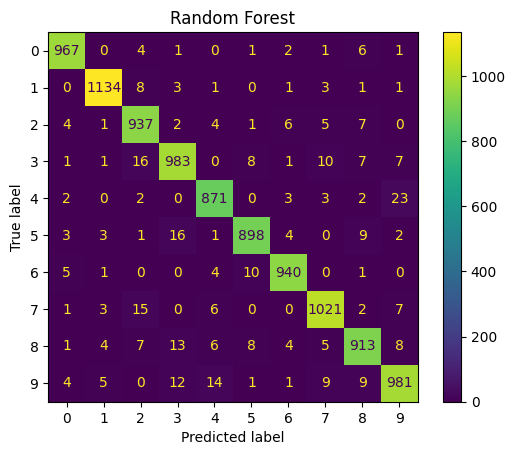

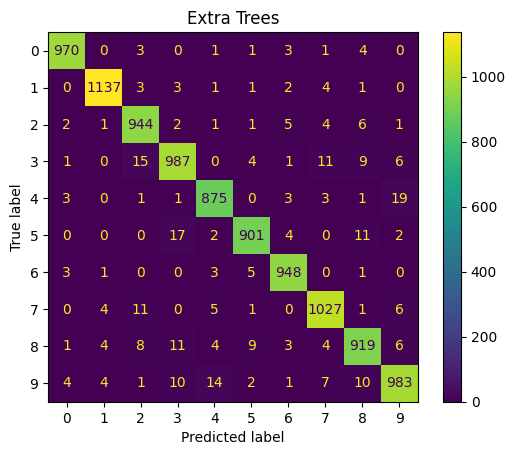

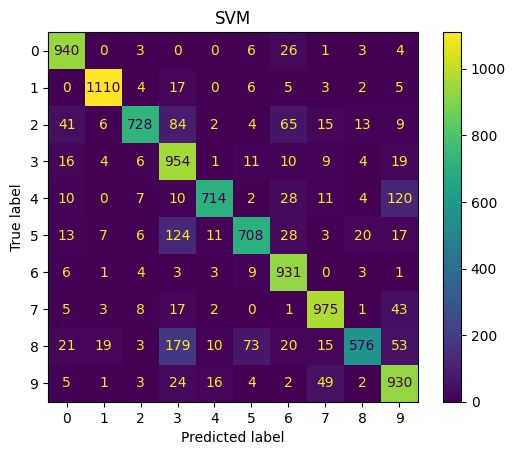

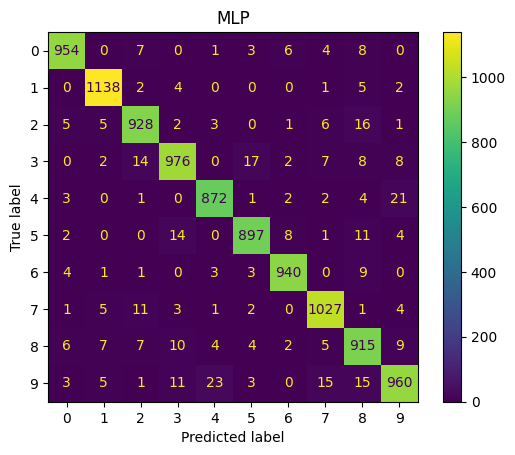

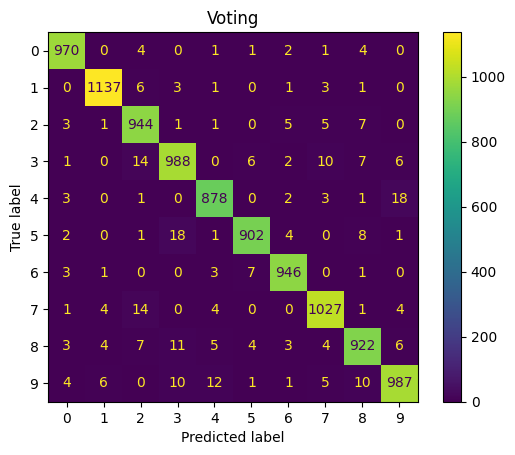

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix for each classifier
for estimator, name in zip([random_forest_clf, extra_trees_clf, svm_clf, mlp_clf, voting_clf_new], ["Random Forest", "Extra Trees", "SVM", "MLP", "Voting"]):
    disp = ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test)
    disp.ax_.set_title(name)
    plt.show()


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score for each classifier
for estimator, name in zip([random_forest_clf, extra_trees_clf, svm_clf, mlp_clf, voting_clf_new], ["Random Forest", "Extra Trees", "SVM", "MLP", "Voting"]):
    y_pred = estimator.predict(X_test)
    print(name)
    print("Precision: ", precision_score(y_test, y_pred, average='weighted'))
    print("Recall: ", recall_score(y_test, y_pred, average='weighted'))
    print("F1 Score: ", f1_score(y_test, y_pred, average='weighted'))
    print()


Random Forest
Precision:  0.964513574364901
Recall:  0.9645
F1 Score:  0.9644858664404704

Extra Trees
Precision:  0.9690985955501463
Recall:  0.9691
F1 Score:  0.9690787218958541

SVM
Precision:  0.8698245360720516
Recall:  0.8566
F1 Score:  0.8548533403304275

MLP
Precision:  0.9607499522309793
Recall:  0.9607
F1 Score:  0.9606820971979443

Voting
Precision:  0.9701259246960561
Recall:  0.9701
F1 Score:  0.9700841003360551



As we see, voting classifier outperforms all of them. Now let us move to the next part:

**Blender**
A blender, also known as a meta-learner, is a model that is trained to make a final prediction based on the predictions of several other models. The idea is to train the blender to recognize when one model’s prediction is likely to be correct and when it’s likely to be wrong, so it can weigh the models’ predictions accordingly.

In our experiment, we trained a blender using the predictions of four classifiers (Random Forest, Extra Trees, SVM, and MLP) on the validation set. The blender was then a Random Forest classifier, which was trained to predict the image’s class based on the predictions of the four classifiers.

**Stacking Classifier**
Stacking (short for stacked generalization) involves training a model to combine the predictions of several other models. The main idea is to use a pool of base models, which are trained based on a complete training set, then train a meta-model that makes a final prediction based on the meta-features, which are the predictions of the base models.

In our experiment, we used a StackingClassifier from sklearn. This classifier takes a list of base classifiers (in our case, Random Forest, Extra Trees, SVM, and MLP) and a final estimator (another Random Forest classifier), which serves as the blender or meta-learner. The StackingClassifier automatically trains the base classifiers on the complete training set, then trains the blender on the base classifiers’ predictions.

In [33]:
import numpy as np

X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)


X_val_predictions is a new training set. Each instance in this new training set is a vector containing the set of predictions
from all classifiers for an image, and the target is the image’s class.

In [34]:
X_valid_predictions

array([['5', '5', '5', '5'],
       ['8', '8', '8', '8'],
       ['2', '2', '3', '2'],
       ...,
       ['7', '7', '7', '7'],
       ['6', '6', '6', '6'],
       ['7', '7', '7', '7']], dtype=object)

So we can train a classifier on this new training set. Let’s use a RandomForestClassifier as the blender:

In [32]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)


RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

Now we evaluate this blender on the test set. For each image in the test set,
make predictions with all classifiers, then feed the predictions to the blender to get the ensemble’s predictions and use evaluation metrics to evaluate performances:


In [35]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

y_pred = rnd_forest_blender.predict(X_test_predictions)


In [37]:
#Let us get accuracy and compare it to voting classifier
from sklearn.metrics import accuracy_score
print("Blender test accuracy: ", accuracy_score(y_test, y_pred))

Blender test accuracy:  0.9687


So, blender's performance is worse than voting classifier's performance, which could be due to complexity of blender or quality of individual predictions.

In [38]:
y_pred_voting = voting_clf_new.predict(X_test)
print("Voting classifier test accuracy: ", accuracy_score(y_test, y_pred_voting))


Voting classifier test accuracy:  0.9701


In [39]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=named_estimators,
    final_estimator=RandomForestClassifier(n_estimators=200, random_state=42),
)
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)
print("Stacking classifier test accuracy: ", accuracy_score(y_test, y_pred_stack))


Stacking classifier test accuracy:  0.9765


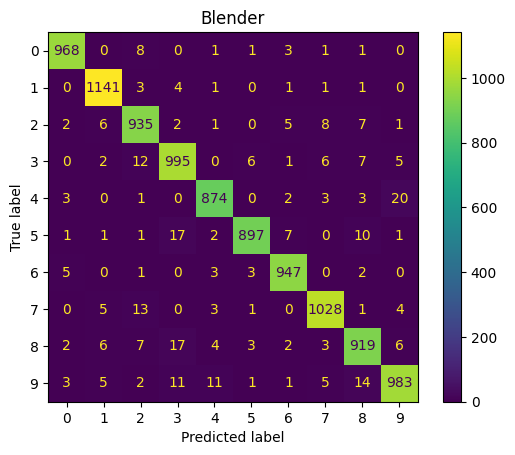

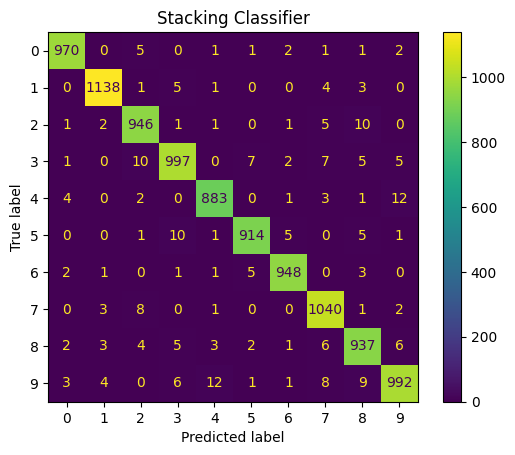

In [41]:
# Plot confusion matrix for the blender and the stacking classifier
for estimator, name in zip([rnd_forest_blender, stacking_clf], ["Blender", "Stacking Classifier"]):
    disp = ConfusionMatrixDisplay.from_estimator(estimator, X_test_predictions if name == "Blender" else X_test, y_test)
    disp.ax_.set_title(name)
    plt.show()


In [42]:
# Calculate precision, recall, and F1 score for the blender and the stacking classifier
for estimator, name in zip([rnd_forest_blender, stacking_clf], ["Blender", "Stacking Classifier"]):
    y_pred = estimator.predict(X_test_predictions if name == "Blender" else X_test)
    print(name)
    print("Precision: ", precision_score(y_test, y_pred, average='weighted'))
    print("Recall: ", recall_score(y_test, y_pred, average='weighted'))
    print("F1 Score: ", f1_score(y_test, y_pred, average='weighted'))
    print()


Blender
Precision:  0.9687508846792794
Recall:  0.9687
F1 Score:  0.9686861387555115

Stacking Classifier
Precision:  0.9765289379606497
Recall:  0.9765
F1 Score:  0.9764934918649673



So, stacking classifier performed best. Improved performance can be attributed to several factors:

**Leveraging Model Strengths:** The stacking classifier learns how to best combine the predictions of the base classifiers. It can learn which classifier performs well under which circumstances and weigh their predictions accordingly. This allows it to leverage the strengths of each individual model more effectively than the voting classifier, which treats all models equally.


**Meta-Learner:** The stacking classifier uses a meta-learner (or blender) that is trained to make the final prediction based on the predictions of the base classifiers. This additional layer of learning can help improve the performance by learning the optimal way to combine the predictions.

**Cross-Validation:** The StackingClassifier in sklearn trains the final estimator (the blender) using cross-validation. This means that it uses different subsets of the training data to train the base classifiers and the blender, which can help prevent overfitting and improve the generalization performance

Thank you!